## Dependencias 

In [27]:
import pandas as pd
from CreditScoringToolkit import DiscreteNormalizer,frequency_table

## Lectura de datos 

In [ ]:
df = pd.read_csv('../data/credit_card_transactions-ibm_v2.csv')
df.shape

In [6]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


## Muestreo Estratificado 

In [12]:
bad = df.loc[df['Is Fraud?']=='Yes'].sample(n=3000).reset_index(drop=True)
good = df.loc[df['Is Fraud?']=='No'].sample(n=3000).reset_index(drop=True)

In [13]:
bad.shape,good.shape

((3000, 15), (3000, 15))

In [14]:
sample = pd.concat([bad,good],ignore_index=True)

## Pre-procesamiento

In [19]:

def preprocess_fraud_data(df_input):
    # Copia para no modificar el original
    df = df_input.copy()
    
    # 1. VARIABLE OBJETIVO: Binaria
    df['target'] = df['Is Fraud?'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0)
    
    # 2. INGENIERÍA DE FECHAS
    # Crear Day of Week antes de borrar Year
    # Usamos pd.to_datetime para asegurar el cálculo correcto del día de la semana
    temp_date = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df['d_DayOfWeek'] = temp_date.dt.day_name()
    
    # 3. TRANSFORMACIÓN DE VARIABLES CONTINUAS (c_)
    # Amount: Quitar '$' y convertir a float
    df['c_Amount'] = df['Amount'].str.replace('$', '').astype(float)
    
    # Time: "13:09" -> (13 * 60) + 9 = 789 minutos
    time_split = df['Time'].str.split(':', expand=True).astype(int)
    df['c_Time_Minutes'] = time_split[0] * 60 + time_split[1]
    
    # 4. VARIABLES DISCRETAS (d_)
    # Prefijar y Limpiar nulos
    discrete_features = {
        'Month': 'd_Month',
        'Day': 'd_Day',
        'Use Chip': 'd_Use_Chip',
        'Merchant City': 'd_Merchant_City',
        'Merchant State': 'd_Merchant_State',
        'MCC': 'd_MCC'
    }
    
    for old_col, new_col in discrete_features.items():
        # Rellenar nulos con 'Unknown' y asegurar que sean strings para el modelo
        df[new_col] = df[old_col].fillna('Unknown').astype(str)
    
    # 5. SELECCIÓN FINAL DE COLUMNAS
    # Solo nos quedamos con las que tienen prefijo c_, d_ y el target
    final_cols = [col for col in df.columns if col.startswith(('c_', 'd_'))] + ['target']
    df_final = df[final_cols]
    
    return df_final

In [62]:
#sample.to_pickle('../data/sample_fraude.pkl')
sample = pd.read_pickle('../data/sample_fraude.pkl')

In [63]:
sample = preprocess_fraud_data(sample)

In [64]:
sample.head()

,d_DayOfWeek,c_Amount,c_Time_Minutes,d_Month,d_Day,d_Use_Chip,d_Merchant_City,d_Merchant_State,d_MCC,target
0,Wednesday,372.00,789,10,15,Swipe Transaction,Mexico City,Mexico,3359,1
1,Sunday,35.72,934,11,22,Chip Transaction,Clyde,TX,5411,1
2,Monday,395.00,721,4,14,Online Transaction,ONLINE,Unknown,3640,1
3,Monday,659.02,829,11,1,Online Transaction,ONLINE,Unknown,3007,1
4,Thursday,130.04,723,4,24,Online Transaction,ONLINE,Unknown,5651,1


## Naturaleza de variables 

In [65]:
vard = [v for v in sample.columns if v[:2]=='d_']
varc = [v for v in sample.columns if v[:2]=='c_']
vart = ['target']
len(vard),len(varc)

(7, 2)

## Normalización de variables discretas 

In [66]:
for v in vard:
    sample[v] = sample[v].fillna('MISSING').astype(str)

for v in varc:
    sample[v] = pd.to_numeric(sample[v],errors='coerce')

In [37]:
frequency_table(sample,vard)

**** Frequency Table for d_DayOfWeek ****

             Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_DayOfWeek                                                          
Friday              950    0.158333              950         0.158333
Monday              813    0.135500             1763         0.293833
Saturday            811    0.135167             2574         0.429000
Sunday              962    0.160333             3536         0.589333
Thursday            922    0.153667             4458         0.743000
Tuesday             855    0.142500             5313         0.885500
Wednesday           687    0.114500             6000         1.000000




**** Frequency Table for d_Month ****

         Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_Month                                                          
1               517    0.086167              517         0.086167
10              550    0.091667             1067         0.177833
11              487 

In [67]:
dn = DiscreteNormalizer(normalization_threshold=0.05)
dn.fit(sample[vard])
sample[vard] = dn.transform(sample[vard])

In [39]:
frequency_table(sample,vard)

**** Frequency Table for d_DayOfWeek ****

             Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_DayOfWeek                                                          
Friday              950    0.158333              950         0.158333
Monday              813    0.135500             1763         0.293833
Saturday            811    0.135167             2574         0.429000
Sunday              962    0.160333             3536         0.589333
Thursday            922    0.153667             4458         0.743000
Tuesday             855    0.142500             5313         0.885500
Wednesday           687    0.114500             6000         1.000000




**** Frequency Table for d_Month ****

         Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_Month                                                          
1               517    0.086167              517         0.086167
10              550    0.091667             1067         0.177833
11              487 

In [40]:
unary = [v for v in vard if sample[v].nunique()==1]
unary

['d_Day']

In [41]:
vard = [v for v in vard if v not in unary]

In [43]:
sample[varc+vard+vart].to_csv('../data/fraud_sample.csv',index=False)

## Infrerencia de modelo Orange

In [45]:
df = pd.read_csv('../data/fraud_sample_qualified.csv')

In [57]:
df['Tree (1)'].value_counts(True)

Tree (1)
0.191470    0.271667
0.946292    0.178889
0.726174    0.167222
0.397436    0.157222
0.053658    0.142778
0.501190    0.082222
Name: proportion, dtype: float64

<Axes: xlabel='Tree (1)'>

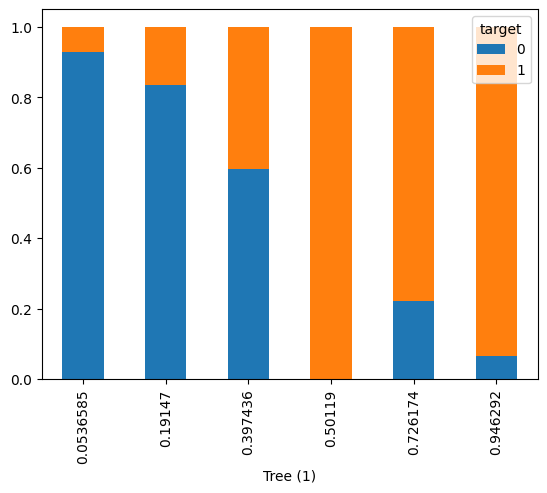

In [56]:
pd.crosstab(df['Tree (1)'],df[vart[0]],normalize='index').plot(kind='bar',stacked=True)

In [69]:
df = pd.read_csv('../data/credit_card_transactions-ibm_v2.csv').sample(100000).reset_index()
df = preprocess_fraud_data(df)

for v in vard:
    df[v] = df[v].fillna('MISSING').astype(str)

for v in varc:
    df[v] = pd.to_numeric(df[v],errors='coerce')

df.to_csv('../data/inferencia.csv')

